In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt

### 2022 Season

In [2]:
data3 = pd.read_gbq('''

WITH games AS (
SELECT DISTINCT game_pk, game_Date FROM `mlb-savant-prod-5db3.savant.onerow_per_pa`
    WHERE game_Date BETWEEN '2022-04-01' AND DATE '2022-09-01' AND game_type = 'R'
),

p AS (
 SELECT  player_id, full_name, MIN(position_name) AS position_name
FROM `mlb-datasci-prod-3f7f.player_stats.player_id`
GROUP BY 1, 2 

),

agg_hitter_stats AS (
  SELECT p.player_id
       , p.full_name AS player_name
       , EXTRACT(month FROM games.game_Date) as month
       , EXTRACT(year FROM games.game_Date) as year
       , CASE
            WHEN p.position_name = 'Outfielder' THEN 0.282
            WHEN p.position_name = 'Catcher'  THEN 0.255
            WHEN p.position_name = 'First Base' THEN 0.300
            WHEN p.position_name = 'Second Base' THEN 0.273
            WHEN p.position_name = 'Third Base' THEN 0.273
            WHEN p.position_name = 'Shortstop' THEN 0.264
            WHEN p.position_name = 'Designated Hitter' THEN 0.309
         END AS owba_constant
       , SUM(at_bats) AS at_bats
       , SUM(base_on_balls) AS base_on_balls
       , SUM(intentional_walks) AS intentional_walks
       , SUM(hit_by_pitches) AS hit_by_pitches
       , SUM(sacrifice_flies) AS sacrifice_flies
       , SUM(hits) AS hits
       , SUM(hits - (doubles + triples + home_runs)) AS singles
       , SUM(doubles) AS doubles
       , SUM(triples) AS triples
       , SUM(home_runs) AS home_runs
    FROM games
    JOIN `mlb-datasci-prod-3f7f.feature_pipeline.game_batting_stats` as batting_stats
        ON games.game_pk = batting_stats.game_pk
    JOIN p
        ON batting_stats.player_id = p.player_id
   WHERE p.position_name <> 'Pitcher'
     AND at_bats > 0
   GROUP BY 1, 2, 3, 4, 5
), hitters AS (
      SELECT player_id
           , player_name
           , month
           , year
           , at_bats
           , (
                (0.69  * (base_on_balls - intentional_walks))
              + (0.72  * hit_by_pitches)
              + (0.88  * singles)
              + (1.247 * doubles)
              + (1.578 * triples)
              + (2.031 * home_runs)
            )/(at_bats + base_on_balls - intentional_walks + sacrifice_flies + hit_by_pitches ) AS owba
           , owba_constant
        FROM agg_hitter_stats
), hitters_war AS (
      SELECT player_id
          , 'H' as pos
          , player_name
          , month
          , year
          , SUM(0.08 * at_bats * (owba - owba_constant)) AS quickwar
       FROM hitters
      GROUP BY 1, 2, 3, 4, 5
), agg_pitching_stats AS (
    SELECT p.player_id
         , p.full_name AS player_name
         , EXTRACT(month FROM games.game_Date) as month
         , EXTRACT(year FROM games.game_Date) as year
         , SUM(innings_pitched) AS innings_pitched
         , SUM(earned_runs) AS earned_runs
      FROM games
      JOIN `mlb-datasci-prod-3f7f.feature_pipeline.game_pitching_stats` AS pitching_stats
          ON games.game_pk = pitching_stats.game_pk
      JOIN p
          ON pitching_stats.player_id = p.player_id
     GROUP BY 1, 2, 3, 4
), pitcher_war AS (
      SELECT player_id
           , player_name
           , month 
           , year
           , 'P' as pos
           , ( (innings_pitched * 0.058) - (earned_runs/10.0) ) AS quickwar
        FROM agg_pitching_stats
), combined AS (
      SELECT players.player_id
           , players.player_name
           , COALESCE(hitters_war.month, pitcher_war.month) AS month
           , COALESCE(hitters_war.year, pitcher_war.year) AS year
           , COALESCE(hitters_war.pos, pitcher_war.pos) AS position
           , COALESCE(hitters_war.quickwar, 0.0) AS hitting_quickwar
           , COALESCE(pitcher_war.quickwar, 0.0) AS pitching_quickwar
           , COALESCE(hitters_war.quickwar, 0.0) + COALESCE(pitcher_war.quickwar, 0.0) AS total_quickwar
        FROM `mlb-datasci-prod-3f7f.player_avidity.most_recent_roster` AS players
   LEFT JOIN hitters_war 
           ON players.player_id = hitters_war.player_id
   LEFT JOIN pitcher_war ON players.player_id = pitcher_war.player_id
   AND hitters_war.month = pitcher_war.month
   AND hitters_war.year = pitcher_war.year
)
SELECT 
     player_id
     , player_name
     , month
     , year
     , position
     , hitting_quickwar
     , pitching_quickwar
     , total_quickwar
     , PERCENT_RANK() OVER (ORDER BY total_quickwar) AS performance_rank
  FROM combined
  
''')

Downloading: 100%|██████████| 2373/2373 [00:00<00:00, 6938.10rows/s]


In [3]:
player_page_loads = pd.read_gbq('''
        

    WITH initial_query AS (

    SELECT DISTINCT page_url, visit, EXTRACT(month FROM date_time_date) as month,
    EXTRACT(year FROM date_time_date) as year
    FROM `mlb-bdataml-prod-da8f.video_recommendation_engine_clickstream.page_loads`

        WHERE (page_url LIKE '%mlb.com/player/%')
        AND date_time_date >= '2022-04-01' AND date_time_date < '2022-8-01'
    )




        SELECT page_url, month, year, count(*) as visits
        FROM initial_query
        GROUP BY page_url, month, year
        ORDER BY 2 desc
        
        


        ''' )

Downloading: 100%|██████████| 1062929/1062929 [00:48<00:00, 21882.72rows/s]


In [6]:
names = []
for i in player_page_loads['page_url']:
    if '?' in i:
        m = re.search('[^\/]+(.)?\?', i)
        temp = m.group(0)
        names.append(temp[:-1])
    else:
        m = re.search('[^/]+(?=/$|$)', i)
        if '#' in m.group(0):
            n = re.search('^[^#]*',m.group(0))
            names.append(n.group(0))
        else:
            names.append(m.group(0))

In [7]:
full_player_page = player_page_loads

In [8]:
def parse_player_ids(player_page):
    #player_page = df.query("source == 'player_page'")
    player_page['player_id'] = player_page['page_url'].str[-6:]
    player_page['is_id'] = player_page['player_id'].str.contains(r'^[0-9]{6}')

    player_page['player_id'] = np.where(player_page.is_id == False, \
                                player_page['page_url'].str.split('?') \
                                        .str[0].str[-6:], player_page.player_id)
    player_page['is_id'] = player_page['player_id'].str.contains(r'^[0-9]{6}')

    player_page['player_id'] = np.where(player_page.is_id == False, \
                               player_page['page_url'].str.split('#') \
                               .str[0].str[-6:], player_page.player_id)
    player_page['is_id'] = player_page['player_id'].str.contains(r'^[0-9]{6}')

    
    player_page = player_page.query("is_id == True") # drop missing player_ids
        
    return player_page

In [11]:
full_player_page = parse_player_ids(player_page_loads)

In [13]:
full_player_page

,page_url,month,year,visits,player_id,is_id
0,https://urldefense.com/v3/__https://www.mlb.com/player/manny-machado-592518__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqWsrx0SXA$,7,2022,41936,592518,True
1,https://urldefense.com/v3/__https://www.mlb.com/player/yoan-lopez-661255__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqWYXxGxOA$,7,2022,3463,661255,True
2,https://urldefense.com/v3/__https://www.mlb.com/player/danny-duffy-518633__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqUWPfEmKQ$,7,2022,1159,518633,True
3,https://urldefense.com/v3/__https://www.mlb.com/player/christopher-morel-6__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqVhXXq-HA$ ...,7,2022,19939,666624,True
4,https://urldefense.com/v3/__https://www.mlb.com/player/brandon-belt-474832__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqUTOT1-hA$,7,2022,8139,474832,True
...,...,...,...,...,...,...
1062924,https://urldefense.com/v3/__https://www.mlb.com/player/zach-jackson-667427__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqWv0cijkQ$ ...,4,2022,1,667427,True
1062925,https://urldefense.com/v3/__https://www.mlb.com/player/miguel-castro-61243__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqWNtMQSKg$ ...,4,2022,1,612434,True
1062926,https://urldefense.com/v3/__https://www.mlb.com/player/seiya-suzuki-673548__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqX_WVUBlQ$ ...,4,2022,1,673548,True
1062927,https://urldefense.com/v3/__https://www.mlb.com/player/eli-morgan-669212?a__;!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqUoNGCj8A$ ...,4,2022,1,669212,True


In [14]:
#full_player_page['construct'] = names
#full_player_page['name'] = full_player_page['construct'].apply(lambda x: "-".join(x.split("-")[:2]))
#full_player_page['name'] = full_player_page['name'].apply(lambda x: x.replace('-',' '))
#full_player_page['player_id'] = full_player_page['construct'].apply(lambda x: x.split('-')[-1:][0])
#full_player_page = full_player_page.head(4000)
#full_player_page['player_id'] = full_player_page['player_id'].str.split('/', expand=True)[0]
full_player_page["is_numeric"] = full_player_page["player_id"].str.isnumeric()
full_player_page = full_player_page.query('is_numeric').reset_index(drop=True)
full_player_page['player_id'] = (pd.to_numeric(full_player_page["player_id"]))
full_player_page['player_id'] = (full_player_page['player_id']).fillna(0.0).astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://urldefense.com/v3/__https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html*returning-a-view-versus-a-copy*5Cn__;IyU!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqXHWaGMrQ$    import sys


In [15]:
pages = full_player_page

In [16]:
pages = pages.groupby(['player_id', 'month', 'year'])['visits'].sum().reset_index()

In [17]:
page_merge22 = pages.merge(data3, how = 'inner', on = ['player_id', 'month', 'year'])

In [18]:
page_merge22.sort_values('visits', ascending = False)

,player_id,month,year,visits,player_name,position,hitting_quickwar,pitching_quickwar,total_quickwar,performance_rank
1151,660271,7,2022,282461,Shohei Ohtani,H,0.051373,0.5558,0.607173,0.958263
1150,660271,6,2022,270868,Shohei Ohtani,H,0.691567,1.1936,1.885167,1.000000
1149,660271,5,2022,254846,Shohei Ohtani,H,0.364956,0.6500,1.014956,0.992833
444,592450,7,2022,196918,Aaron Judge,H,1.523140,0.0000,1.523140,0.997892
1148,660271,4,2022,186029,Shohei Ohtani,H,-0.008576,0.4380,0.429424,0.924536
...,...,...,...,...,...,...,...,...,...,...
1088,656514,7,2022,1108,Adam Haseley,H,0.025280,0.0000,0.025280,0.731872
516,595956,5,2022,1062,Cameron Gallagher,H,0.050000,0.0000,0.050000,0.752951
761,621450,6,2022,893,Skye Bolt,H,-0.090240,0.0000,-0.090240,0.184654
732,621006,7,2022,883,Richard Martin,H,0.000000,0.0000,0.000000,0.263069


In [19]:
page_merge22.corr(method = 'pearson')

,player_id,month,year,visits,hitting_quickwar,pitching_quickwar,total_quickwar,performance_rank
player_id,1.000000,0.022214,NaN,-0.073139,0.045675,0.044049,0.051846,0.043034
month,0.022214,1.000000,NaN,0.015484,0.089502,-0.012126,0.085467,0.065898
year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
visits,-0.073139,0.015484,NaN,1.000000,0.304946,0.433077,0.368913,0.231001
hitting_quickwar,0.045675,0.089502,NaN,0.304946,1.000000,0.057535,0.986535,0.832111
pitching_quickwar,0.044049,-0.012126,NaN,0.433077,0.057535,1.000000,0.220041,0.125668
total_quickwar,0.051846,0.085467,NaN,0.368913,0.986535,0.220041,1.000000,0.833651
performance_rank,0.043034,0.065898,NaN,0.231001,0.832111,0.125668,0.833651,1.000000


In [20]:
sns.set_style('darkgrid')

[Text(0.5, 1.0, 'Total Quickwar v Visits')]

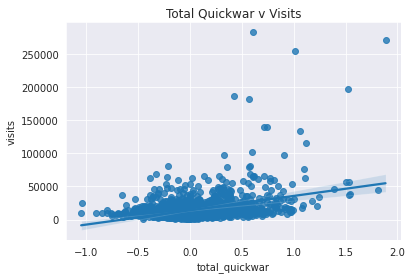

In [21]:
sns.regplot(data=page_merge22, x="total_quickwar", y="visits").set(title='Total Quickwar v Visits')

### 2021 season

In [22]:
data3 = pd.read_gbq('''

WITH games AS (
SELECT DISTINCT game_pk, game_Date FROM `mlb-savant-prod-5db3.savant.onerow_per_pa`
    WHERE game_Date BETWEEN '2021-04-01' AND DATE '2021-10-04' AND game_type = 'R'
),

p AS (
 SELECT  player_id, full_name, MIN(position_name) AS position_name
FROM `mlb-datasci-prod-3f7f.player_stats.player_id`
GROUP BY 1, 2 

),

agg_hitter_stats AS (
  SELECT p.player_id
       , p.full_name AS player_name
       , EXTRACT(month FROM games.game_Date) as month
       , EXTRACT(year FROM games.game_Date) as year
       , CASE
            WHEN p.position_name = 'Outfielder' THEN 0.282
            WHEN p.position_name = 'Catcher'  THEN 0.255
            WHEN p.position_name = 'First Base' THEN 0.300
            WHEN p.position_name = 'Second Base' THEN 0.273
            WHEN p.position_name = 'Third Base' THEN 0.273
            WHEN p.position_name = 'Shortstop' THEN 0.264
            WHEN p.position_name = 'Designated Hitter' THEN 0.309
         END AS owba_constant
       , SUM(at_bats) AS at_bats
       , SUM(base_on_balls) AS base_on_balls
       , SUM(intentional_walks) AS intentional_walks
       , SUM(hit_by_pitches) AS hit_by_pitches
       , SUM(sacrifice_flies) AS sacrifice_flies
       , SUM(hits) AS hits
       , SUM(hits - (doubles + triples + home_runs)) AS singles
       , SUM(doubles) AS doubles
       , SUM(triples) AS triples
       , SUM(home_runs) AS home_runs
    FROM games
    JOIN `mlb-datasci-prod-3f7f.feature_pipeline.game_batting_stats` as batting_stats
        ON games.game_pk = batting_stats.game_pk
    JOIN p
        ON batting_stats.player_id = p.player_id
   WHERE p.position_name <> 'Pitcher'
     AND at_bats > 0
   GROUP BY 1, 2, 3, 4, 5
), hitters AS (
      SELECT player_id
           , player_name
           , month
           , year
           , at_bats
           , (
                (0.69  * (base_on_balls - intentional_walks))
              + (0.72  * hit_by_pitches)
              + (0.88  * singles)
              + (1.247 * doubles)
              + (1.578 * triples)
              + (2.031 * home_runs)
            )/(at_bats + base_on_balls - intentional_walks + sacrifice_flies + hit_by_pitches ) AS owba
           , owba_constant
        FROM agg_hitter_stats
), hitters_war AS (
      SELECT player_id
          , 'H' as pos
          , player_name
          , month
          , year
          , SUM(0.08 * at_bats * (owba - owba_constant)) AS quickwar
       FROM hitters
      GROUP BY 1, 2, 3, 4, 5
), agg_pitching_stats AS (
    SELECT p.player_id
         , p.full_name AS player_name
         , EXTRACT(month FROM games.game_Date) as month
         , EXTRACT(year FROM games.game_Date) as year
         , SUM(innings_pitched) AS innings_pitched
         , SUM(earned_runs) AS earned_runs
      FROM games
      JOIN `mlb-datasci-prod-3f7f.feature_pipeline.game_pitching_stats` AS pitching_stats
          ON games.game_pk = pitching_stats.game_pk
      JOIN p
          ON pitching_stats.player_id = p.player_id
     GROUP BY 1, 2, 3, 4
), pitcher_war AS (
      SELECT player_id
           , player_name
           , month 
           , year
           , 'P' as pos
           , ( (innings_pitched * 0.058) - (earned_runs/10.0) ) AS quickwar
        FROM agg_pitching_stats
), combined AS (
      SELECT players.player_id
           , players.player_name
           , COALESCE(hitters_war.month, pitcher_war.month) AS month
           , COALESCE(hitters_war.year, pitcher_war.year) AS year
           , COALESCE(hitters_war.pos, pitcher_war.pos) AS position
           , COALESCE(hitters_war.quickwar, 0.0) AS hitting_quickwar
           , COALESCE(pitcher_war.quickwar, 0.0) AS pitching_quickwar
           , COALESCE(hitters_war.quickwar, 0.0) + COALESCE(pitcher_war.quickwar, 0.0) AS total_quickwar
        FROM `mlb-datasci-prod-3f7f.player_avidity.most_recent_roster` AS players
   LEFT JOIN hitters_war 
           ON players.player_id = hitters_war.player_id
   LEFT JOIN pitcher_war ON players.player_id = pitcher_war.player_id
   AND hitters_war.month = pitcher_war.month
   AND hitters_war.year = pitcher_war.year
)
SELECT 
     player_id
     , player_name
     , month
     , year
     , position
     , hitting_quickwar
     , pitching_quickwar
     , total_quickwar
     , PERCENT_RANK() OVER (ORDER BY total_quickwar) AS performance_rank
  FROM combined
  
''')

Downloading: 100%|██████████| 3509/3509 [00:00<00:00, 8918.12rows/s]


In [23]:
player_page_loads = pd.read_gbq('''
        

    WITH initial_query AS (

    SELECT DISTINCT page_url, visit, EXTRACT(month FROM date_time_date) as month,
    EXTRACT(year FROM date_time_date) as year
    FROM `mlb-bdataml-prod-da8f.video_recommendation_engine_clickstream.page_loads`

        WHERE (page_url LIKE '%mlb.com/player/%')
        AND date_time_date >= '2021-04-01' AND date_time_date < '2021-10-04'
    )




        SELECT page_url, month, year, count(*) as visits
        FROM initial_query
        GROUP BY page_url, month, year
        ORDER BY 2 desc
        
        


        ''' )

Downloading: 100%|██████████| 414696/414696 [00:14<00:00, 29520.54rows/s]


In [24]:
names = []
for i in player_page_loads['page_url']:
    if '?' in i:
        m = re.search('[^\/]+(.)?\?', i)
        temp = m.group(0)
        names.append(temp[:-1])
    else:
        m = re.search('[^/]+(?=/$|$)', i)
        if '#' in m.group(0):
            n = re.search('^[^#]*',m.group(0))
            names.append(n.group(0))
        else:
            names.append(m.group(0))

In [25]:
full_player_page = player_page_loads

In [27]:
def parse_player_ids(player_page):
    #player_page = df.query("source == 'player_page'")
    player_page['player_id'] = player_page['page_url'].str[-6:]
    player_page['is_id'] = player_page['player_id'].str.contains(r'^[0-9]{6}')

    player_page['player_id'] = np.where(player_page.is_id == False, \
                                player_page['page_url'].str.split('?') \
                                        .str[0].str[-6:], player_page.player_id)
    player_page['is_id'] = player_page['player_id'].str.contains(r'^[0-9]{6}')

    player_page['player_id'] = np.where(player_page.is_id == False, \
                               player_page['page_url'].str.split('#') \
                               .str[0].str[-6:], player_page.player_id)
    player_page['is_id'] = player_page['player_id'].str.contains(r'^[0-9]{6}')

    
    player_page = player_page.query("is_id == True") # drop missing player_ids
        
    return player_page

In [29]:
full_player_page = parse_player_ids(player_page_loads)

In [30]:
full_player_page["is_numeric"] = full_player_page["player_id"].str.isnumeric()
full_player_page = full_player_page.query('is_numeric').reset_index(drop=True)
full_player_page['player_id'] = (pd.to_numeric(full_player_page["player_id"]))
full_player_page['player_id'] = (full_player_page['player_id']).fillna(0.0).astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://urldefense.com/v3/__https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html*returning-a-view-versus-a-copy*5Cn__;IyU!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqXHWaGMrQ$    """Entry point for launching an IPython kernel.


In [31]:
pages = full_player_page

In [32]:
pages = pages.groupby(['player_id', 'month', 'year'])['visits'].sum().reset_index()

In [33]:
page_merge21 = pages.merge(data3, how = 'inner', on = ['player_id', 'month', 'year'])

In [35]:
page_merge21.corr(method = 'pearson')

,player_id,month,year,visits,hitting_quickwar,pitching_quickwar,total_quickwar,performance_rank
player_id,1.000000,0.006105,NaN,-0.068000,-0.024107,-0.073153,-0.057551,-0.068406
month,0.006105,1.000000,NaN,-0.128983,-0.097034,-0.086926,-0.129379,-0.108571
year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
visits,-0.068000,-0.128983,NaN,1.000000,0.252892,0.257887,0.352635,0.248271
hitting_quickwar,-0.024107,-0.097034,NaN,0.252892,1.000000,-0.043557,0.870403,0.800395
pitching_quickwar,-0.073153,-0.086926,NaN,0.257887,-0.043557,1.000000,0.453960,0.298152
total_quickwar,-0.057551,-0.129379,NaN,0.352635,0.870403,0.453960,1.000000,0.860779
performance_rank,-0.068406,-0.108571,NaN,0.248271,0.800395,0.298152,0.860779,1.000000


[Text(0.5, 1.0, 'Total Quickwar v Visits')]

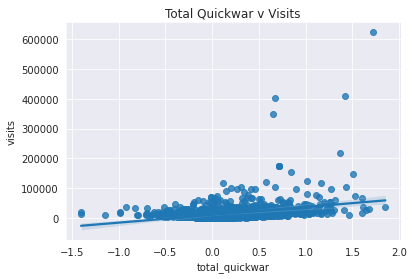

In [37]:
sns.regplot(data=page_merge21, x="total_quickwar", y="visits").set(title='Total Quickwar v Visits')

In [185]:
concatenated = pd.concat([page_merge21.assign(dataset='2021'), page_merge22.assign(dataset='2022')])

In [188]:
concatenated.sort_values('total_quickwar', ascending = False)

,player_id,month,year,visits,player_name,position,hitting_quickwar,pitching_quickwar,total_quickwar,performance_rank,dataset
1150,660271,6,2022,270868,Shohei Ohtani,H,0.691567,1.1936,1.885167,1.000000,2022
12,425794,8,2021,38135,Adam Wainwright,H,0.000000,1.8520,1.852000,0.999430,2021
105,502671,5,2022,45008,Paul Goldschmidt,H,1.815523,0.0000,1.815523,0.999578,2022
1508,660271,7,2021,623024,Shohei Ohtani,H,0.858257,0.8600,1.718257,0.998575,2021
922,608331,9,2021,29334,Max Fried,H,0.000000,1.6780,1.678000,0.998290,2021
...,...,...,...,...,...,...,...,...,...,...,...
512,595879,5,2022,25032,Ednel Baez,H,-1.044158,0.0000,-1.044158,0.000422,2022
963,642165,7,2022,9901,Josh VanMeter,H,-0.364267,-0.6840,-1.048267,0.000000,2022
1613,664058,9,2021,11502,David Fletcher,H,-1.143928,0.0000,-1.143928,0.000570,2021
812,605200,9,2021,12497,Zachary Davies,H,0.000000,-1.3982,-1.398200,0.000285,2021


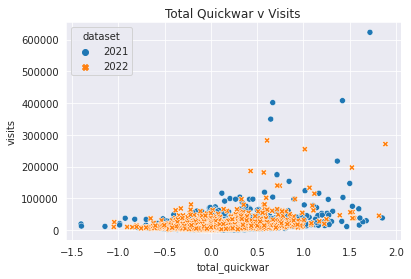

In [183]:
sns.scatterplot(x='total_quickwar', y='visits', data=concatenated,
                hue='dataset', style='dataset').set(title='Total Quickwar v Visits')
plt.show()

In [120]:
concatenated

,player_id,month,year,visits,player_name,position,hitting_quickwar,pitching_quickwar,total_quickwar,performance_rank,dataset
0,405395,6,2021,73088,Jose Pujols,H,-0.012640,0.0,-0.012640,0.197147,4/21-5/21
1,408234,6,2021,43210,Jose Cabrera,H,0.071280,0.0,0.071280,0.776872,4/21-5/21
2,425877,6,2021,13234,Yadier Molina,H,-0.081600,0.0,-0.081600,0.129394,4/21-5/21
3,435559,6,2021,7314,Kurt Suzuki,H,-0.020400,0.0,-0.020400,0.190525,4/21-5/21
4,443558,6,2021,22596,Nelson Cruz,H,0.056704,0.0,0.056704,0.766684,4/21-5/21
...,...,...,...,...,...,...,...,...,...,...,...
218,670768,6,2022,18774,Luis Gonzalez,H,-0.067680,0.0,-0.067680,0.159139,4/22-5/22
219,671277,6,2022,12829,Luis Garcia,H,0.000000,0.0,0.000000,0.225840,4/22-5/22
220,672386,6,2022,46674,Alejandro Kirk,H,-0.102000,0.0,-0.102000,0.117647,4/22-5/22
221,673357,6,2022,16285,Luis Robert,H,-0.019840,0.0,-0.019840,0.209034,4/22-5/22


In [123]:
concatenated.corr(method = 'pearson')

,player_id,month,year,visits,hitting_quickwar,pitching_quickwar,total_quickwar,performance_rank
player_id,1.000000,-0.003383,0.017983,-0.068802,0.005096,-0.046854,-0.013770,-0.017668
month,-0.003383,1.000000,-0.684775,-0.071258,0.040189,0.012266,0.041980,0.001397
year,0.017983,-0.684775,1.000000,0.015445,-0.084204,-0.092189,-0.114181,-0.040828
visits,-0.068802,-0.071258,0.015445,1.000000,0.266321,0.268091,0.351869,0.235942
hitting_quickwar,0.005096,0.040189,-0.084204,0.266321,1.000000,-0.013299,0.918953,0.814328
pitching_quickwar,-0.046854,0.012266,-0.092189,0.268091,-0.013299,1.000000,0.382112,0.231583
total_quickwar,-0.013770,0.041980,-0.114181,0.351869,0.918953,0.382112,1.000000,0.843937
performance_rank,-0.017668,0.001397,-0.040828,0.235942,0.814328,0.231583,0.843937,1.000000


In [182]:
concatenated.sort_values('visits', ascending = False).head(20)

,player_id,month,year,visits,player_name,position,hitting_quickwar,pitching_quickwar,total_quickwar,performance_rank,dataset
1508,660271,7,2021,623024,Shohei Ohtani,H,0.858257,0.8600,1.718257,0.998575,2021
1507,660271,6,2021,407859,Shohei Ohtani,H,1.375670,0.0456,1.421270,0.994584,2021
1509,660271,8,2021,401691,Shohei Ohtani,H,0.018253,0.6500,0.668253,0.930730,2021
1510,660271,9,2021,349601,Shohei Ohtani,H,0.290434,0.3558,0.646234,0.924173,2021
1151,660271,7,2022,282461,Shohei Ohtani,H,0.051373,0.5558,0.607173,0.958263,2022
1150,660271,6,2022,270868,Shohei Ohtani,H,0.691567,1.1936,1.885167,1.000000,2022
1149,660271,5,2022,254846,Shohei Ohtani,H,0.364956,0.6500,1.014956,0.992833,2022
668,594798,6,2021,217276,Jacob deGrom,H,0.000000,1.3660,1.366000,0.994014,2021
444,592450,7,2022,196918,Aaron Judge,H,1.523140,0.0000,1.523140,0.997892,2022
1148,660271,4,2022,186029,Shohei Ohtani,H,-0.008576,0.4380,0.429424,0.924536,2022


### End of used analysis. All below was test work that did not end up getting used!

### Predictive Section

In [103]:
data3 = pd.read_gbq('''

WITH games AS (
SELECT DISTINCT game_pk, game_Date FROM `mlb-savant-prod-5db3.savant.onerow_per_pa`
    WHERE game_Date BETWEEN '2021-04-01' AND DATE '2021-6-01' AND game_type = 'R'
),

p AS (
 SELECT  player_id, full_name, MIN(position_name) AS position_name
FROM `mlb-datasci-prod-3f7f.player_stats.player_id`
GROUP BY 1, 2 

),

agg_hitter_stats AS (
  SELECT p.player_id
       , p.full_name AS player_name
       , EXTRACT(month FROM games.game_Date) as month
       , EXTRACT(year FROM games.game_Date) as year
       , CASE
            WHEN p.position_name = 'Outfielder' THEN 0.282
            WHEN p.position_name = 'Catcher'  THEN 0.255
            WHEN p.position_name = 'First Base' THEN 0.300
            WHEN p.position_name = 'Second Base' THEN 0.273
            WHEN p.position_name = 'Third Base' THEN 0.273
            WHEN p.position_name = 'Shortstop' THEN 0.264
            WHEN p.position_name = 'Designated Hitter' THEN 0.309
         END AS owba_constant
       , SUM(at_bats) AS at_bats
       , SUM(base_on_balls) AS base_on_balls
       , SUM(intentional_walks) AS intentional_walks
       , SUM(hit_by_pitches) AS hit_by_pitches
       , SUM(sacrifice_flies) AS sacrifice_flies
       , SUM(hits) AS hits
       , SUM(hits - (doubles + triples + home_runs)) AS singles
       , SUM(doubles) AS doubles
       , SUM(triples) AS triples
       , SUM(home_runs) AS home_runs
    FROM games
    JOIN `mlb-datasci-prod-3f7f.feature_pipeline.game_batting_stats` as batting_stats
        ON games.game_pk = batting_stats.game_pk
    JOIN p
        ON batting_stats.player_id = p.player_id
   WHERE p.position_name <> 'Pitcher'
     AND at_bats > 0
   GROUP BY 1, 2, 3, 4, 5
), hitters AS (
      SELECT player_id
           , player_name
           , month
           , year
           , at_bats
           , (
                (0.69  * (base_on_balls - intentional_walks))
              + (0.72  * hit_by_pitches)
              + (0.88  * singles)
              + (1.247 * doubles)
              + (1.578 * triples)
              + (2.031 * home_runs)
            )/(at_bats + base_on_balls - intentional_walks + sacrifice_flies + hit_by_pitches ) AS owba
           , owba_constant
        FROM agg_hitter_stats
), hitters_war AS (
      SELECT player_id
          , 'H' as pos
          , player_name
          , month
          , year
          , SUM(0.08 * at_bats * (owba - owba_constant)) AS quickwar
       FROM hitters
      GROUP BY 1, 2, 3, 4, 5
), agg_pitching_stats AS (
    SELECT p.player_id
         , p.full_name AS player_name
         , EXTRACT(month FROM games.game_Date) as month
         , EXTRACT(year FROM games.game_Date) as year
         , SUM(innings_pitched) AS innings_pitched
         , SUM(earned_runs) AS earned_runs
      FROM games
      JOIN `mlb-datasci-prod-3f7f.feature_pipeline.game_pitching_stats` AS pitching_stats
          ON games.game_pk = pitching_stats.game_pk
      JOIN p
          ON pitching_stats.player_id = p.player_id
     GROUP BY 1, 2, 3, 4
), pitcher_war AS (
      SELECT player_id
           , player_name
           , month 
           , year
           , 'P' as pos
           , ( (innings_pitched * 0.058) - (earned_runs/10.0) ) AS quickwar
        FROM agg_pitching_stats
), combined AS (
      SELECT players.player_id
           , players.player_name
           , COALESCE(hitters_war.month, pitcher_war.month) AS month
           , COALESCE(hitters_war.year, pitcher_war.year) AS year
           , COALESCE(hitters_war.pos, pitcher_war.pos) AS position
           , COALESCE(hitters_war.quickwar, 0.0) AS hitting_quickwar
           , COALESCE(pitcher_war.quickwar, 0.0) AS pitching_quickwar
           , COALESCE(hitters_war.quickwar, 0.0) + COALESCE(pitcher_war.quickwar, 0.0) AS total_quickwar
        FROM `mlb-datasci-prod-3f7f.player_avidity.most_recent_roster` AS players
   LEFT JOIN hitters_war 
           ON players.player_id = hitters_war.player_id
   LEFT JOIN pitcher_war ON players.player_id = pitcher_war.player_id
   AND hitters_war.month = pitcher_war.month
   AND hitters_war.year = pitcher_war.year
)
SELECT 
     player_id
     , player_name
     , month
     , year
     , position
     , hitting_quickwar
     , pitching_quickwar
     , total_quickwar
     , PERCENT_RANK() OVER (ORDER BY total_quickwar) AS performance_rank
  FROM combined
  
''')

Downloading: 100%|██████████| 1964/1964 [00:00<00:00, 6978.90rows/s]


In [104]:
player_page_loads = pd.read_gbq('''
        

    WITH initial_query AS (

    SELECT DISTINCT page_url, visit, EXTRACT(month FROM date_time_date) as month,
    EXTRACT(year FROM date_time_date) as year
    FROM `mlb-bdataml-prod-da8f.video_recommendation_engine_clickstream.page_loads`

        WHERE (page_url LIKE '%mlb.com/player/%')
        AND date_time_date >= '2021-6-01' AND date_time_date < '2021-07-01'
    )




        SELECT page_url, month, year, count(*) as visits
        FROM initial_query
        GROUP BY page_url, month, year
        ORDER BY 2 desc
        
        


        ''' )

Downloading: 100%|██████████| 95709/95709 [00:03<00:00, 27813.72rows/s]


In [105]:
names = []
for i in player_page_loads['page_url']:
    if '?' in i:
        m = re.search('[^\/]+(.)?\?', i)
        temp = m.group(0)
        names.append(temp[:-1])
    else:
        m = re.search('[^/]+(?=/$|$)', i)
        if '#' in m.group(0):
            n = re.search('^[^#]*',m.group(0))
            names.append(n.group(0))
        else:
            names.append(m.group(0))

In [106]:
full_player_page = player_page_loads

In [47]:
def parse_player_ids(player_page):
    #player_page = df.query("source == 'player_page'")
    player_page['player_id'] = player_page['page_url'].str[-6:]
    player_page['is_id'] = player_page['player_id'].str.contains(r'^[0-9]{6}')

    player_page['player_id'] = np.where(player_page.is_id == False, \
                                player_page['page_url'].str.split('?') \
                                        .str[0].str[-6:], player_page.player_id)
    player_page['is_id'] = player_page['player_id'].str.contains(r'^[0-9]{6}')

    player_page['player_id'] = np.where(player_page.is_id == False, \
                               player_page['page_url'].str.split('#') \
                               .str[0].str[-6:], player_page.player_id)
    player_page['is_id'] = player_page['player_id'].str.contains(r'^[0-9]{6}')

    
    player_page = player_page.query("is_id == True") # drop missing player_ids
        
    return player_page

In [107]:
full_player_page = parse_player_ids(player_page_loads)

In [108]:
full_player_page["is_numeric"] = full_player_page["player_id"].str.isnumeric()
full_player_page = full_player_page.query('is_numeric').reset_index(drop=True)
full_player_page['player_id'] = (pd.to_numeric(full_player_page["player_id"]))
full_player_page['player_id'] = (full_player_page['player_id']).fillna(0.0).astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://urldefense.com/v3/__https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html*returning-a-view-versus-a-copy*5Cn__;IyU!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqXHWaGMrQ$    """Entry point for launching an IPython kernel.


In [109]:
pages = full_player_page

In [110]:
pages = pages.groupby(['player_id', 'month', 'year'])['visits'].sum().reset_index()

In [111]:
page_merge21_1 = pages.merge(data3, how = 'inner', on = ['player_id', 'month', 'year'])

In [112]:
page_merge21_1.corr(method = 'pearson')

,player_id,month,year,visits,hitting_quickwar,pitching_quickwar,total_quickwar,performance_rank
player_id,1.000000,NaN,NaN,-0.022280,0.017927,-0.015127,0.009430,-0.060455
month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
visits,-0.022280,NaN,NaN,1.000000,0.173885,0.007074,0.159145,0.122587
hitting_quickwar,0.017927,NaN,NaN,0.173885,1.000000,0.001489,0.897987,0.825370
pitching_quickwar,-0.015127,NaN,NaN,0.007074,0.001489,1.000000,0.441359,0.150205
total_quickwar,0.009430,NaN,NaN,0.159145,0.897987,0.441359,1.000000,0.806725
performance_rank,-0.060455,NaN,NaN,0.122587,0.825370,0.150205,0.806725,1.000000


In [54]:
#2021 pt2

In [135]:
data3 = pd.read_gbq('''

WITH games AS (
SELECT DISTINCT game_pk, game_Date FROM `mlb-savant-prod-5db3.savant.onerow_per_pa`
    WHERE game_Date BETWEEN '2021-05-01' AND DATE '2021-6-30' AND game_type = 'R'
),

p AS (
 SELECT  player_id, full_name, MIN(position_name) AS position_name
FROM `mlb-datasci-prod-3f7f.player_stats.player_id`
GROUP BY 1, 2 

),

agg_hitter_stats AS (
  SELECT p.player_id
       , p.full_name AS player_name
       , EXTRACT(month FROM games.game_Date) as month
       , EXTRACT(year FROM games.game_Date) as year
       , CASE
            WHEN p.position_name = 'Outfielder' THEN 0.282
            WHEN p.position_name = 'Catcher'  THEN 0.255
            WHEN p.position_name = 'First Base' THEN 0.300
            WHEN p.position_name = 'Second Base' THEN 0.273
            WHEN p.position_name = 'Third Base' THEN 0.273
            WHEN p.position_name = 'Shortstop' THEN 0.264
            WHEN p.position_name = 'Designated Hitter' THEN 0.309
         END AS owba_constant
       , SUM(at_bats) AS at_bats
       , SUM(base_on_balls) AS base_on_balls
       , SUM(intentional_walks) AS intentional_walks
       , SUM(hit_by_pitches) AS hit_by_pitches
       , SUM(sacrifice_flies) AS sacrifice_flies
       , SUM(hits) AS hits
       , SUM(hits - (doubles + triples + home_runs)) AS singles
       , SUM(doubles) AS doubles
       , SUM(triples) AS triples
       , SUM(home_runs) AS home_runs
    FROM games
    JOIN `mlb-datasci-prod-3f7f.feature_pipeline.game_batting_stats` as batting_stats
        ON games.game_pk = batting_stats.game_pk
    JOIN p
        ON batting_stats.player_id = p.player_id
   WHERE p.position_name <> 'Pitcher'
     AND at_bats > 0
   GROUP BY 1, 2, 3, 4, 5
), hitters AS (
      SELECT player_id
           , player_name
           , month
           , year
           , at_bats
           , (
                (0.69  * (base_on_balls - intentional_walks))
              + (0.72  * hit_by_pitches)
              + (0.88  * singles)
              + (1.247 * doubles)
              + (1.578 * triples)
              + (2.031 * home_runs)
            )/(at_bats + base_on_balls - intentional_walks + sacrifice_flies + hit_by_pitches ) AS owba
           , owba_constant
        FROM agg_hitter_stats
), hitters_war AS (
      SELECT player_id
          , 'H' as pos
          , player_name
          , month
          , year
          , SUM(0.08 * at_bats * (owba - owba_constant)) AS quickwar
       FROM hitters
      GROUP BY 1, 2, 3, 4, 5
), agg_pitching_stats AS (
    SELECT p.player_id
         , p.full_name AS player_name
         , EXTRACT(month FROM games.game_Date) as month
         , EXTRACT(year FROM games.game_Date) as year
         , SUM(innings_pitched) AS innings_pitched
         , SUM(earned_runs) AS earned_runs
      FROM games
      JOIN `mlb-datasci-prod-3f7f.feature_pipeline.game_pitching_stats` AS pitching_stats
          ON games.game_pk = pitching_stats.game_pk
      JOIN p
          ON pitching_stats.player_id = p.player_id
     GROUP BY 1, 2, 3, 4
), pitcher_war AS (
      SELECT player_id
           , player_name
           , month 
           , year
           , 'P' as pos
           , ( (innings_pitched * 0.058) - (earned_runs/10.0) ) AS quickwar
        FROM agg_pitching_stats
), combined AS (
      SELECT players.player_id
           , players.player_name
           , COALESCE(hitters_war.month, pitcher_war.month) AS month
           , COALESCE(hitters_war.year, pitcher_war.year) AS year
           , COALESCE(hitters_war.pos, pitcher_war.pos) AS position
           , COALESCE(hitters_war.quickwar, 0.0) AS hitting_quickwar
           , COALESCE(pitcher_war.quickwar, 0.0) AS pitching_quickwar
           , COALESCE(hitters_war.quickwar, 0.0) + COALESCE(pitcher_war.quickwar, 0.0) AS total_quickwar
        FROM `mlb-datasci-prod-3f7f.player_avidity.most_recent_roster` AS players
   LEFT JOIN hitters_war 
           ON players.player_id = hitters_war.player_id
   LEFT JOIN pitcher_war ON players.player_id = pitcher_war.player_id
   AND hitters_war.month = pitcher_war.month
   AND hitters_war.year = pitcher_war.year
)
SELECT 
     player_id
     , player_name
     , month
     , year
     , position
     , hitting_quickwar
     , pitching_quickwar
     , total_quickwar
     , PERCENT_RANK() OVER (ORDER BY total_quickwar) AS performance_rank
  FROM combined
  
''')

Downloading: 100%|██████████| 1710/1710 [00:00<00:00, 6622.02rows/s]


In [155]:
player_page_loads = pd.read_gbq('''
        

    WITH initial_query AS (

    SELECT DISTINCT page_url, visit, EXTRACT(month FROM date_time_date) as month,
    EXTRACT(year FROM date_time_date) as year,
    EXTRACT(month FROM date_time_date)-1 as join_month
    FROM `mlb-bdataml-prod-da8f.video_recommendation_engine_clickstream.page_loads`

        WHERE (page_url LIKE '%mlb.com/player/%')
        AND date_time_date >= '2021-7-01' AND date_time_date < '2021-08-01'
    )




        SELECT page_url, month, join_month, year, count(*) as visits
        FROM initial_query
        GROUP BY page_url, month, join_month, year
        ORDER BY 2 desc
        
        


        ''' )

Downloading: 100%|██████████| 110222/110222 [00:04<00:00, 23476.18rows/s]


In [156]:
names = []
for i in player_page_loads['page_url']:
    if '?' in i:
        m = re.search('[^\/]+(.)?\?', i)
        temp = m.group(0)
        names.append(temp[:-1])
    else:
        m = re.search('[^/]+(?=/$|$)', i)
        if '#' in m.group(0):
            n = re.search('^[^#]*',m.group(0))
            names.append(n.group(0))
        else:
            names.append(m.group(0))

In [157]:
full_player_page = player_page_loads

In [158]:
full_player_page = parse_player_ids(player_page_loads)

In [159]:
full_player_page["is_numeric"] = full_player_page["player_id"].str.isnumeric()
full_player_page = full_player_page.query('is_numeric').reset_index(drop=True)
full_player_page['player_id'] = (pd.to_numeric(full_player_page["player_id"]))
full_player_page['player_id'] = (full_player_page['player_id']).fillna(0.0).astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://urldefense.com/v3/__https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html*returning-a-view-versus-a-copy*5Cn__;IyU!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqXHWaGMrQ$    """Entry point for launching an IPython kernel.


In [162]:
pages = full_player_page

In [163]:
pages = pages.groupby(['player_id', 'month', 'join_month', 'year'])['visits'].sum().reset_index()

In [164]:
pages.head(5)

,player_id,month,join_month,year,visits
0,489,7,6,2021,1
1,961,7,6,2021,1
2,2203,7,6,2021,2
3,2598,7,6,2021,2
4,2756,7,6,2021,1


In [165]:
data3['join_month'] = 6

In [166]:
page_merge21_2 = pages.merge(data3, how = 'inner', on = ['player_id', 'join_month', 'year'])

In [168]:
page_merge21_2.query('join_month == 6')

,player_id,month_x,join_month,year,visits,player_name,month_y,position,hitting_quickwar,pitching_quickwar,total_quickwar,performance_rank
0,405395,7,6,2021,69792,Jose Pujols,5.0,H,-0.098959,0.0000,-0.098959,0.094792
1,405395,7,6,2021,69792,Jose Pujols,6.0,H,0.047602,0.0000,0.047602,0.750146
2,408234,7,6,2021,61909,Jose Cabrera,5.0,H,-0.442394,0.0000,-0.442394,0.009947
3,408234,7,6,2021,61909,Jose Cabrera,6.0,H,0.373093,0.0000,0.373093,0.887068
4,425794,7,6,2021,23630,Adam Wainwright,5.0,H,0.000000,0.2574,0.257400,0.850790
...,...,...,...,...,...,...,...,...,...,...,...,...
771,671277,7,6,2021,4673,Luis Garcia,5.0,H,0.000000,0.0000,0.000000,0.141018
772,671277,7,6,2021,4673,Luis Garcia,6.0,H,0.000000,0.0000,0.000000,0.141018
773,672386,7,6,2021,5357,Alejandro Kirk,5.0,H,0.007200,0.0000,0.007200,0.722060
774,673357,7,6,2021,4617,Luis Robert,5.0,H,0.028000,0.0000,0.028000,0.734933


In [169]:
page_merge21_2.corr(method = 'pearson')

,player_id,month_x,join_month,year,visits,month_y,hitting_quickwar,pitching_quickwar,total_quickwar,performance_rank
player_id,1.000000,NaN,NaN,NaN,-0.052886,0.006724,0.011383,-0.085437,-0.039435,-0.063709
month_x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
join_month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
visits,-0.052886,NaN,NaN,NaN,1.000000,-0.009916,0.226132,0.223432,0.324210,0.198825
month_y,0.006724,NaN,NaN,NaN,-0.009916,1.000000,0.069307,-0.016836,0.050168,0.026537
hitting_quickwar,0.011383,NaN,NaN,NaN,0.226132,0.069307,1.000000,-0.079212,0.818255,0.722907
pitching_quickwar,-0.085437,NaN,NaN,NaN,0.223432,-0.016836,-0.079212,1.000000,0.508235,0.276334
total_quickwar,-0.039435,NaN,NaN,NaN,0.324210,0.050168,0.818255,0.508235,1.000000,0.783896
performance_rank,-0.063709,NaN,NaN,NaN,0.198825,0.026537,0.722907,0.276334,0.783896,1.000000


In [136]:
data3

,player_id,player_name,month,year,position,hitting_quickwar,pitching_quickwar,total_quickwar,performance_rank
0,596748,Maikel Franco,5.0,2021.0,H,-0.893711,0.0000,-0.893711,0.000000
1,598265,Jackie Bradley,5.0,2021.0,H,-0.801738,0.0000,-0.801738,0.000585
2,624585,Jorge Soler,5.0,2021.0,H,-0.726544,0.0000,-0.726544,0.001170
3,543333,Eric Hosmer,6.0,2021.0,H,-0.709621,0.0000,-0.709621,0.001755
4,592178,Kristopher Bryant,6.0,2021.0,H,-0.699050,0.0000,-0.699050,0.002341
...,...,...,...,...,...,...,...,...,...
1705,656941,Kyle Schwarber,6.0,2021.0,H,1.597655,0.0000,1.597655,0.997659
1706,656775,Boyce Mullins,6.0,2021.0,H,1.641878,0.0000,1.641878,0.998245
1707,592332,Kevin Gausman,5.0,2021.0,H,0.000000,1.8460,1.846000,0.998830
1708,605540,Brandon Woodruff,5.0,2021.0,H,0.000000,1.8548,1.854800,0.999415


In [137]:
page_merge21_2

,player_id,month,year,visits,player_name,position,hitting_quickwar,pitching_quickwar,total_quickwar,performance_rank
0,425794,7,2021,23630,Adam Wainwright,H,0.00000,0.264,0.26400,0.865560
1,425877,7,2021,16126,Yadier Molina,H,-0.08160,0.000,-0.08160,0.108731
2,443558,7,2021,46741,Nelson Cruz,H,0.05792,0.000,0.05792,0.757900
3,444482,7,2021,7896,Senger Peralta,H,0.02736,0.000,0.02736,0.728441
4,453568,7,2021,11575,Charles Blackmon,H,-0.09888,0.000,-0.09888,0.088913
...,...,...,...,...,...,...,...,...,...,...
155,669289,7,2021,9297,Santiago Espinal,H,0.00000,0.000,0.00000,0.167649
156,669374,7,2021,8252,Keston Hiura,H,0.00352,0.000,0.00352,0.708623
157,670032,7,2021,5796,Nicholas Lopez,H,0.00000,0.000,0.00000,0.167649
158,670541,7,2021,17562,Yordan Alvarez,H,0.08700,0.000,0.08700,0.779861


In [138]:
data3['month'].unique()

array([ 5.,  6., nan])

In [140]:
data3.query('month == 6')

,player_id,player_name,month,year,position,hitting_quickwar,pitching_quickwar,total_quickwar,performance_rank
3,543333,Eric Hosmer,6.0,2021.0,H,-0.709621,0.0000,-0.709621,0.001755
4,592178,Kristopher Bryant,6.0,2021.0,H,-0.699050,0.0000,-0.699050,0.002341
5,607536,Kyle Freeland,6.0,2021.0,H,0.000000,-0.5544,-0.554400,0.002926
6,641531,Hunter Dozier,6.0,2021.0,H,-0.542821,0.0000,-0.542821,0.003511
7,596103,Austin Slater,6.0,2021.0,H,-0.516278,0.0000,-0.516278,0.004096
...,...,...,...,...,...,...,...,...,...
1700,594798,Jacob deGrom,6.0,2021.0,H,0.000000,1.3660,1.366000,0.994734
1701,660271,Shohei Ohtani,6.0,2021.0,H,1.375670,0.0456,1.421270,0.995319
1704,665489,Vladimir Guerrero,6.0,2021.0,H,1.500221,0.0000,1.500221,0.997074
1705,656941,Kyle Schwarber,6.0,2021.0,H,1.597655,0.0000,1.597655,0.997659


In [126]:
pages['player_']

,player_id,month,year,visits
0,20470,6,2021,1
1,40880,6,2021,1
2,43913,6,2021,1
3,57607,6,2021,2
4,68734,6,2021,2
...,...,...,...,...
37856,947581,6,2021,1
37857,950312,6,2021,1
37858,964174,6,2021,2
37859,984772,6,2021,1


### 2022 section

In [92]:
data3 = pd.read_gbq('''

WITH games AS (
SELECT DISTINCT game_pk, game_Date FROM `mlb-savant-prod-5db3.savant.onerow_per_pa`
    WHERE game_Date BETWEEN '2022-04-01' AND DATE '2022-6-01' AND game_type = 'R'
),

p AS (
 SELECT  player_id, full_name, MIN(position_name) AS position_name
FROM `mlb-datasci-prod-3f7f.player_stats.player_id`
GROUP BY 1, 2 

),

agg_hitter_stats AS (
  SELECT p.player_id
       , p.full_name AS player_name
       , EXTRACT(month FROM games.game_Date) as month
       , EXTRACT(year FROM games.game_Date) as year
       , CASE
            WHEN p.position_name = 'Outfielder' THEN 0.282
            WHEN p.position_name = 'Catcher'  THEN 0.255
            WHEN p.position_name = 'First Base' THEN 0.300
            WHEN p.position_name = 'Second Base' THEN 0.273
            WHEN p.position_name = 'Third Base' THEN 0.273
            WHEN p.position_name = 'Shortstop' THEN 0.264
            WHEN p.position_name = 'Designated Hitter' THEN 0.309
         END AS owba_constant
       , SUM(at_bats) AS at_bats
       , SUM(base_on_balls) AS base_on_balls
       , SUM(intentional_walks) AS intentional_walks
       , SUM(hit_by_pitches) AS hit_by_pitches
       , SUM(sacrifice_flies) AS sacrifice_flies
       , SUM(hits) AS hits
       , SUM(hits - (doubles + triples + home_runs)) AS singles
       , SUM(doubles) AS doubles
       , SUM(triples) AS triples
       , SUM(home_runs) AS home_runs
    FROM games
    JOIN `mlb-datasci-prod-3f7f.feature_pipeline.game_batting_stats` as batting_stats
        ON games.game_pk = batting_stats.game_pk
    JOIN p
        ON batting_stats.player_id = p.player_id
   WHERE p.position_name <> 'Pitcher'
     AND at_bats > 0
   GROUP BY 1, 2, 3, 4, 5
), hitters AS (
      SELECT player_id
           , player_name
           , month
           , year
           , at_bats
           , (
                (0.69  * (base_on_balls - intentional_walks))
              + (0.72  * hit_by_pitches)
              + (0.88  * singles)
              + (1.247 * doubles)
              + (1.578 * triples)
              + (2.031 * home_runs)
            )/(at_bats + base_on_balls - intentional_walks + sacrifice_flies + hit_by_pitches ) AS owba
           , owba_constant
        FROM agg_hitter_stats
), hitters_war AS (
      SELECT player_id
          , 'H' as pos
          , player_name
          , month
          , year
          , SUM(0.08 * at_bats * (owba - owba_constant)) AS quickwar
       FROM hitters
      GROUP BY 1, 2, 3, 4, 5
), agg_pitching_stats AS (
    SELECT p.player_id
         , p.full_name AS player_name
         , EXTRACT(month FROM games.game_Date) as month
         , EXTRACT(year FROM games.game_Date) as year
         , SUM(innings_pitched) AS innings_pitched
         , SUM(earned_runs) AS earned_runs
      FROM games
      JOIN `mlb-datasci-prod-3f7f.feature_pipeline.game_pitching_stats` AS pitching_stats
          ON games.game_pk = pitching_stats.game_pk
      JOIN p
          ON pitching_stats.player_id = p.player_id
     GROUP BY 1, 2, 3, 4
), pitcher_war AS (
      SELECT player_id
           , player_name
           , month 
           , year
           , 'P' as pos
           , ( (innings_pitched * 0.058) - (earned_runs/10.0) ) AS quickwar
        FROM agg_pitching_stats
), combined AS (
      SELECT players.player_id
           , players.player_name
           , COALESCE(hitters_war.month, pitcher_war.month) AS month
           , COALESCE(hitters_war.year, pitcher_war.year) AS year
           , COALESCE(hitters_war.pos, pitcher_war.pos) AS position
           , COALESCE(hitters_war.quickwar, 0.0) AS hitting_quickwar
           , COALESCE(pitcher_war.quickwar, 0.0) AS pitching_quickwar
           , COALESCE(hitters_war.quickwar, 0.0) + COALESCE(pitcher_war.quickwar, 0.0) AS total_quickwar
        FROM `mlb-datasci-prod-3f7f.player_avidity.most_recent_roster` AS players
   LEFT JOIN hitters_war 
           ON players.player_id = hitters_war.player_id
   LEFT JOIN pitcher_war ON players.player_id = pitcher_war.player_id
   AND hitters_war.month = pitcher_war.month
   AND hitters_war.year = pitcher_war.year
)
SELECT 
     player_id
     , player_name
     , month
     , year
     , position
     , hitting_quickwar
     , pitching_quickwar
     , total_quickwar
     , PERCENT_RANK() OVER (ORDER BY total_quickwar) AS performance_rank
  FROM combined
  
''')

Downloading: 100%|██████████| 1905/1905 [00:00<00:00, 6835.18rows/s]


In [93]:
player_page_loads = pd.read_gbq('''
        

    WITH initial_query AS (

    SELECT DISTINCT page_url, visit, EXTRACT(month FROM date_time_date) as month,
    EXTRACT(year FROM date_time_date) as year
    FROM `mlb-bdataml-prod-da8f.video_recommendation_engine_clickstream.page_loads`

        WHERE (page_url LIKE '%mlb.com/player/%')
        AND date_time_date >= '2022-06-01' AND date_time_date < '2022-07-01'
    )




        SELECT page_url, month, year, count(*) as visits
        FROM initial_query
        GROUP BY page_url, month, year
        ORDER BY 2 desc
        
        


        ''' )

Downloading: 100%|██████████| 256374/256374 [00:13<00:00, 18372.36rows/s]


In [94]:
names = []
for i in player_page_loads['page_url']:
    if '?' in i:
        m = re.search('[^\/]+(.)?\?', i)
        temp = m.group(0)
        names.append(temp[:-1])
    else:
        m = re.search('[^/]+(?=/$|$)', i)
        if '#' in m.group(0):
            n = re.search('^[^#]*',m.group(0))
            names.append(n.group(0))
        else:
            names.append(m.group(0))

In [95]:
full_player_page = player_page_loads

In [96]:
full_player_page = parse_player_ids(player_page_loads)

In [97]:
full_player_page["is_numeric"] = full_player_page["player_id"].str.isnumeric()
full_player_page = full_player_page.query('is_numeric').reset_index(drop=True)
full_player_page['player_id'] = (pd.to_numeric(full_player_page["player_id"]))
full_player_page['player_id'] = (full_player_page['player_id']).fillna(0.0).astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://urldefense.com/v3/__https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html*returning-a-view-versus-a-copy*5Cn__;IyU!!Mih3wA!Ek7nlM8V8AZCy_6UlJYr65LfRvD9ZjQk2iwdXVNmdCqXn2REIaSmy_HgJrpQwVhkVESbYCs4pPocoqXHWaGMrQ$    """Entry point for launching an IPython kernel.


In [98]:
pages = full_player_page

In [99]:
pages = pages.groupby(['player_id', 'month', 'year'])['visits'].sum().reset_index()

In [101]:
page_merge22_1 = pages.merge(data3, how = 'inner', on = ['player_id', 'month', 'year'])

In [102]:
page_merge22_1.corr(method = 'pearson')

,player_id,month,year,visits,hitting_quickwar,pitching_quickwar,total_quickwar,performance_rank
player_id,1.000000,NaN,NaN,-0.092822,0.021618,-0.068204,0.017950,-0.039063
month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
visits,-0.092822,NaN,NaN,1.000000,0.043370,-0.034563,0.041445,0.076768
hitting_quickwar,0.021618,NaN,NaN,0.043370,1.000000,0.012264,0.998589,0.840074
pitching_quickwar,-0.068204,NaN,NaN,-0.034563,0.012264,1.000000,0.065356,0.074749
total_quickwar,0.017950,NaN,NaN,0.041445,0.998589,0.065356,1.000000,0.842311
performance_rank,-0.039063,NaN,NaN,0.076768,0.840074,0.074749,0.842311,1.000000


### Test Concat

In [170]:
concatenated = pd.concat([page_merge21_1.assign(dataset='4/21-5/21'), page_merge21_2.assign(dataset='5/21-6/21') 
                         , page_merge22_1.assign(dataset='4/22-5/22')])

In [171]:
concatenated.sort_values('total_quickwar', ascending = False)

,player_id,month,year,visits,player_name,position,hitting_quickwar,pitching_quickwar,total_quickwar,performance_rank,dataset,month_x,join_month,month_y
141,543760,NaN,2021,29181,Marcus Semien,H,1.926039,0.0000,1.926039,1.000000,5/21-6/21,7.0,6.0,5.0
367,605540,NaN,2021,28406,Brandon Woodruff,H,0.000000,1.8548,1.854800,0.999415,5/21-6/21,7.0,6.0,5.0
252,592332,NaN,2021,44691,Kevin Gausman,H,0.000000,1.8460,1.846000,0.998830,5/21-6/21,7.0,6.0,5.0
630,656775,NaN,2021,28109,Boyce Mullins,H,1.641878,0.0000,1.641878,0.998245,5/21-6/21,7.0,6.0,6.0
634,656941,NaN,2021,46470,Kyle Schwarber,H,1.597655,0.0000,1.597655,0.997659,5/21-6/21,7.0,6.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,592178,NaN,2021,65991,Kristopher Bryant,H,-0.699050,0.0000,-0.699050,0.002341,5/21-6/21,7.0,6.0,6.0
129,543333,NaN,2021,25044,Eric Hosmer,H,-0.709621,0.0000,-0.709621,0.001755,5/21-6/21,7.0,6.0,6.0
498,624585,NaN,2021,19216,Jorge Soler,H,-0.726544,0.0000,-0.726544,0.001170,5/21-6/21,7.0,6.0,5.0
330,598265,NaN,2021,13037,Jackie Bradley,H,-0.801738,0.0000,-0.801738,0.000585,5/21-6/21,7.0,6.0,5.0


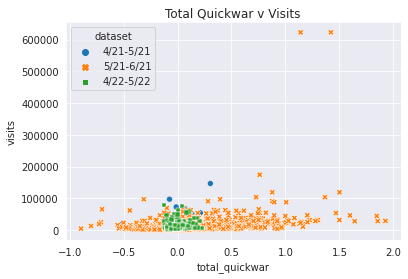

In [174]:
sns.scatterplot(x='total_quickwar', y='visits', data=concatenated,
                hue='dataset', style='dataset').set(title='Total Quickwar v Visits')
plt.show()